<a href="https://colab.research.google.com/github/tilopez/GO_distance/blob/master/6_dist_con_umbral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distancias y resultados esperados

## Toolboxes y funciones

In [0]:
# Toolboxes 
!pip install pygsp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.metrics import accuracy_score
from pygsp import graphs, filters, plotting
np.set_printoptions(suppress=True)



# Función para evaluar la matriz de resultados esperados, a partir de las distancias
def exp_matrix( dist, exp ):
  dist = dist.round(8)
  rta = np.zeros(exp.shape)
  [n,m] = exp.shape

  for i in range(n):
    fila_dist = np.concatenate((dist[i,0:i],dist[i,i+1:n]))
    comps = np.zeros(m)
    cont = 0
    for j in range(n-2):
      for k in range(j+1,n-1):
        comps[cont] = 0 if fila_dist[j] < fila_dist[k] else 1 if fila_dist[j] == fila_dist[k] else 2
        cont = cont + 1
    rta[i,:] = comps

  eva = []
  genes = []
  cant = 0

  for i in range(n):
    word = []
    for j in range(m):
      if rta[i,j] == exp[i,j]:
        word.append("right")
      else:      
        word.append("WRONG")
        cant += 1
        
        # determinar los genes que dieron el error
        cont = 0
        for k in range(n-1):
          for l in range(k,n):
            if k != i and l != i and k != l:
              if cont == j:
                genes.append([i+1, k+1, l+1])
              cont += 1

    eva.append(word)

  return(eva,cant,genes)



# Función que evalua los resultados esperados, modificada para evaluar con un umbral
def exp_matrix_u( dist, exp, gamma ):
  dist = dist.round(8)
  rta = np.zeros(exp.shape)
  [n,m] = exp.shape

  for i in range(n):
    fila_dist = np.concatenate((dist[i,0:i],dist[i,i+1:n]))
    comps = np.zeros(m)
    cont = 0
    for j in range(n-2):
      for k in range(j+1,n-1):
#       umbral agregado
        
        if abs(fila_dist[j] - fila_dist[k]) > gamma:
          if fila_dist[j] < fila_dist[k]:
            comps[cont] = 0
          else:
            comps[cont] = 2
        else:
          comps[cont] = 1

        cont = cont + 1
    rta[i,:] = comps

  eva = []
  genes = []
  cant = 0

  for i in range(n):
    word = []
    for j in range(m):
      if rta[i,j] == exp[i,j]:
        word.append("right")
      else:      
        word.append("WRONG")
        cant += 1
        
        # determinar los genes que dieron el error
        cont = 0
        for k in range(n-1):
          for l in range(k,n):
            if k != i and l != i and k != l:
              if cont == j:
                genes.append([i+1, k+1, l+1])
              cont += 1

    eva.append(word)

  return(eva,cant,genes) 



# Función para crear genes con 0s y 1s 
def labgene(labs,N):
  g = np.zeros(N)
  for i in labs:
    g[i] = 1
  return g



# Función para graficar genes a partir de los índices en el arreglo de genes
def plot_genes( id_genes ):
  
  for i in range(len(id_genes)):
    id_genes[i] = id_genes[i] - 1

  if len(id_genes)>3:
    size_x = 20
  elif len(id_genes)>2:
    size_x = 15
  else:
    size_x = 10


  fig, ax = plt.subplots(1, len(id_genes), figsize=(size_x,4))
  for i in range(len(id_genes)):
    ax1 = plt.subplot(1, len(id_genes), i+1);
    G.plot_signal(genes[id_genes[i]], ax=ax1, plot_name=id_genes[i]+1)



# Distancia coseno 
def dist_cos(v1, v2):
  punto = 0
  for i in range(len(v1)):
    punto += v1[i]*v2[i]
  norm1 = np.sqrt(sum(np.power(v1,2)))
  norm2 = np.sqrt(sum(np.power(v2,2)))
  return 1 - punto/(norm1*norm2)



# Accuracy 
def dist_accu(v1, v2):
  cont = 0
  for i in range(len(v1)):
    if v1[i] == v2[i]:
      cont += 1
  return 1 - cont/len(v1)



## Grafo y genes

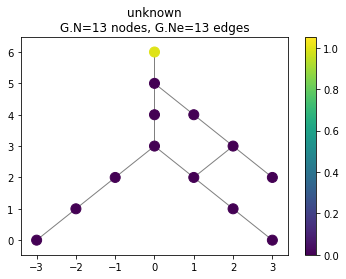

In [0]:
# Definición del grafo 
ini = np.array([0, 1, 1, 2, 3, 4, 4, 5, 5, 6, 7,  9,  10])
fin = np.array([1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12])

N = fin.max()+1
A = np.zeros((N,N))

for i, f in zip(ini, fin):
    A[i,f] = 1
A = A + A.T

# Matriz de grado
d = np.sum(A,1)
D = np.diag(d)

# Laplaciano
L = D - A

G = graphs.Graph(A)

coords = [[0, 6], [0, 5], [0, 4], [1, 4], [0, 3], [2, 3], [-1, 2], [1, 2], [3, 2], [-2, 1], [2, 1], [-3, 0], [3, 0]]
G.set_coordinates(coords)

G.plot_signal(np.concatenate(([1],[0]*12)))

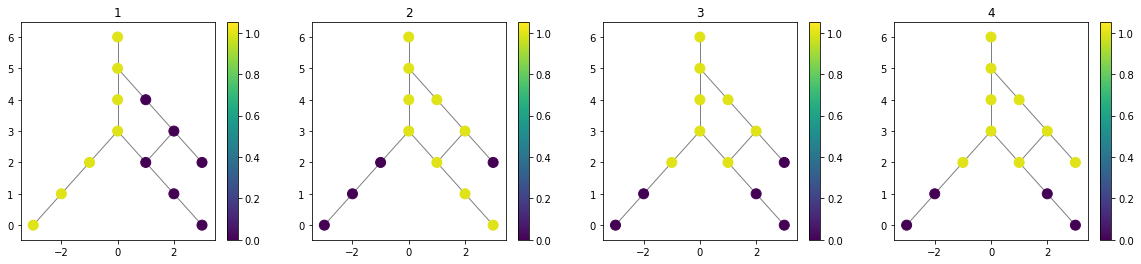

In [0]:
# Genes 
genes = []
genes.append(labgene([0,1,2,4,6,9,11],N))
genes.append(labgene([0,1,2,3,4,5,7,10,12],N))
genes.append(labgene([0,1,2,3,4,5,6,7],N))
genes.append(labgene([0,1,2,3,4,5,6,7,8],N))

n = len(genes)
strgen = "gen "

plotting.BACKEND = 'matplotlib'
fig, ax = plt.subplots(1, n, figsize=(20,4))

for i in range(n):
    ax1 = plt.subplot(1, n, i+1)
    G.plot_signal(genes[i], ax=ax1, plot_name=strgen.join(str(i+1)))

## Diccionarios y base

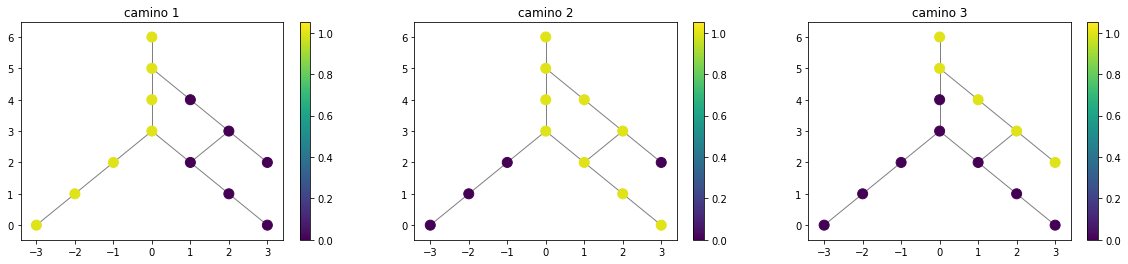

In [0]:
# Diccionario de un elemento por hoja 
d1_camino1 = labgene([0,1,2,4,6,9,11],N)
d1_camino2 = labgene([0,1,2,3,4,5,7,10,12],N)
d1_camino3 = labgene([0,1,3,5,8],N)

plotting.BACKEND = 'matplotlib'
fig, ax = plt.subplots(1, 3, figsize=(20,4))

ax1 = plt.subplot(1, 3, 1);     G.plot_signal(d1_camino1, ax=ax1, plot_name="camino 1")
ax1 = plt.subplot(1, 3, 2);     G.plot_signal(d1_camino2, ax=ax1, plot_name="camino 2")
ax1 = plt.subplot(1, 3, 3);     G.plot_signal(d1_camino3, ax=ax1, plot_name="camino 3")

D1 = np.column_stack((d1_camino1, d1_camino2, d1_camino3)).T

d1=np.sum(D1.T,axis=0)
idx1=np.argsort(d1)
D1=D1[idx1,:]

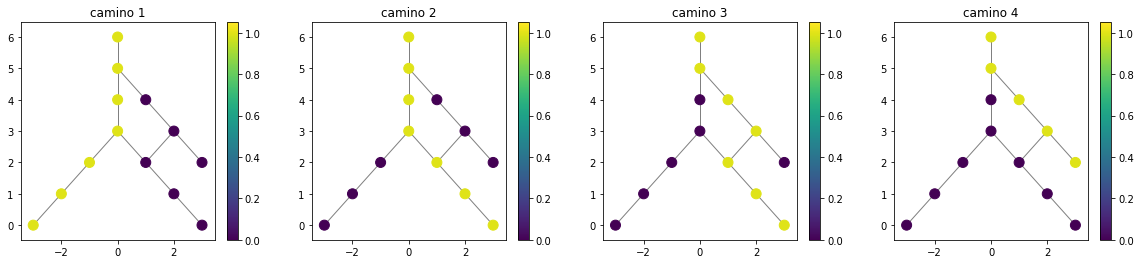

In [0]:
# Diccionarios de todos los caminos a las hojas 
d2_camino1 = labgene([0,1,2,4,6,9,11],N)
d2_camino2 = labgene([0,1,2,4,7,10,12],N)
d2_camino3 = labgene([0,1,3,5,7,10,12],N)
d2_camino4 = labgene([0,1,3,5,8],N)

plotting.BACKEND = 'matplotlib'
fig, ax = plt.subplots(1, 4, figsize=(20,4))

ax1 = plt.subplot(1, 4, 1);     G.plot_signal(d2_camino1, ax=ax1, plot_name="camino 1")
ax1 = plt.subplot(1, 4, 2);     G.plot_signal(d2_camino2, ax=ax1, plot_name="camino 2")
ax1 = plt.subplot(1, 4, 3);     G.plot_signal(d2_camino3, ax=ax1, plot_name="camino 3")
ax1 = plt.subplot(1, 4, 4);     G.plot_signal(d2_camino4, ax=ax1, plot_name="camino 4")

D2 = np.column_stack((d2_camino1, d2_camino2, d2_camino3, d2_camino4)).T

d2=np.sum(D2.T,axis=0)
idx2=np.argsort(d2)
D2=D2[idx2,:]

In [0]:
# Base del laplaciano 
autoval, autovec = np.linalg.eigh(L)
idx = autoval.argsort()
val = autoval[idx]
B = autovec[:,idx]

## Calcular las distancias

In [0]:
# Definir si se muestran las distancias 
mostrar_distancias = 0

# Cálculo de las distancias 
dist_D1 = np.zeros((n,n))
dist_D2 = np.zeros((n,n))
dist_B = np.zeros((n,n))
dist_C = np.zeros((n,n))
dist_A = np.zeros((n,n))
genes = np.column_stack(genes).T

ggf1 = np.dot(D1, genes.T).T
for i in range(n):
  for j in range(i,n):
    dist_D1[i,j] = np.linalg.norm(ggf1[i,:]-ggf1[j,:])
dist_D1 = dist_D1 + dist_D1.T

ggf2 = np.dot(D2, genes.T).T
for i in range(n):
  for j in range(i,n):
    dist_D2[i,j] = np.linalg.norm(ggf2[i,:]-ggf2[j,:])
dist_D2 = dist_D2 + dist_D2.T

# el laplaciano va transpuesto
ggf3 = np.dot(B.T, genes.T).T
for i in range(n):
  for j in range(i,n):
    dist_B[i,j] = np.linalg.norm(ggf3[i,:]-ggf3[j,:])
dist_B = dist_B + dist_B.T

# distancia coseno
for i in range(n):
  for j in range(i,n):
    dist_C[i,j] = spatial.distance.cosine(genes[i],genes[j])
dist_C = dist_C + dist_C.T

# accuracy
for i in range(n):
  for j in range(i,n):
    dist_A[i,j] = 1 - accuracy_score(genes[i], genes[j])
dist_A = dist_A + dist_A.T

if mostrar_distancias == 1:
  noms = []
  for i in range(n):
    noms.append(strgen.join(str(i+1)))

  print("\n Caminos únicos a las hojas")
  frame1 = pd.DataFrame(dist_D1, noms, noms)
  print(frame1) 

  print("\n Todos los caminos posibles a las hojas")
  frame2 = pd.DataFrame(dist_D2, noms, noms)
  print(frame2)

  print("\n Laplaciano")
  frame3 = pd.DataFrame(dist_B, noms, noms)
  print(frame3)

  print("\n Distancia Coseno")
  frame4 = pd.DataFrame(dist_C, noms, noms)
  print(frame4) 

  print("\n Accuracy")
  frame5 = pd.DataFrame(dist_A, noms, noms)
  print(frame5) 

In [0]:
# Normalizar las distancias 
gen0 = np.zeros((13,1))
gen1 = np.ones((13,1))

ggf1_0 = np.dot(D1,gen0)
ggf1_1 = np.dot(D1,gen1)
dist_max_D1 = np.linalg.norm(ggf1_0-ggf1_1)

ggf2_0 = np.dot(D2,gen0)
ggf2_1 = np.dot(D2,gen1)
dist_max_D2 = np.linalg.norm(ggf2_0-ggf2_1)

dist_max_B = 13 #sum(sum(np.power(B,2)))

# distancias normalizadas
n_dist_D1 = dist_D1/dist_max_D1
n_dist_D2 = dist_D2/dist_max_D2
n_dist_B = dist_B/dist_max_B
n_dist_C = dist_C
n_dist_A = dist_A

## Resultados esperados

In [0]:
# matriz de datos esperados
n = 4
m = 0
for i in range(2,n):
  m = m + n - i
exp = np.zeros((n,m))

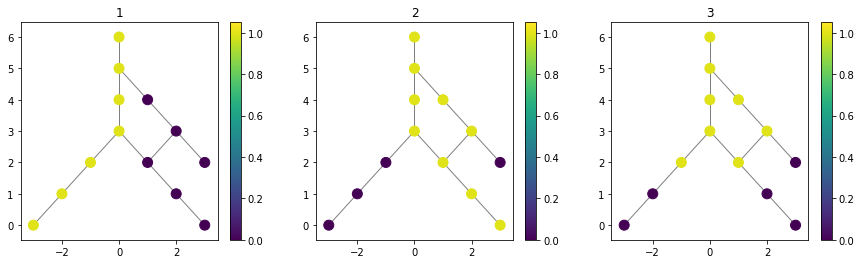

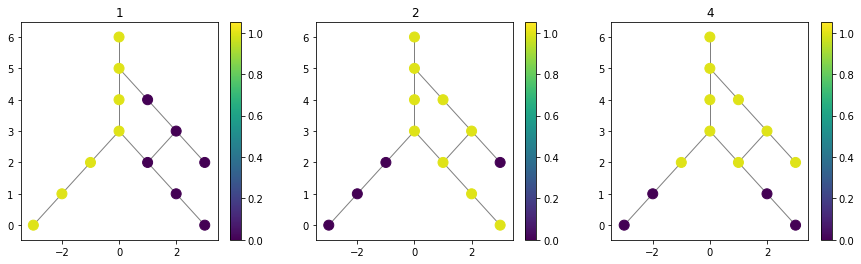

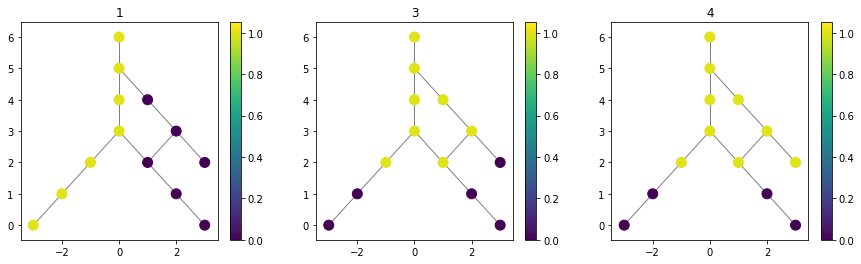

In [0]:
exp[0,0]=2 # 1,2,3        por la cantidad de nodos en común, el 1 con el 3 tienen un nodo en comun mas que el 1 con el 2
exp[0,1]=2 # 1,2,4        por la cantidad de nodos en común, el 1 con el 4 tienen 1 etiqueta positiva a favor y 2 etiqueta negativa a favor, y el 1 con el 2 tiene 1 negativa en contra
exp[0,2]=0 # 1,3,4        por la cantidad de nodos de diferencia, porque el 4 tiene mas nodos positivos en la rama en la que no tendria que tener nada
plot_genes([1,2,3])
plot_genes([1,2,4])
plot_genes([1,3,4])

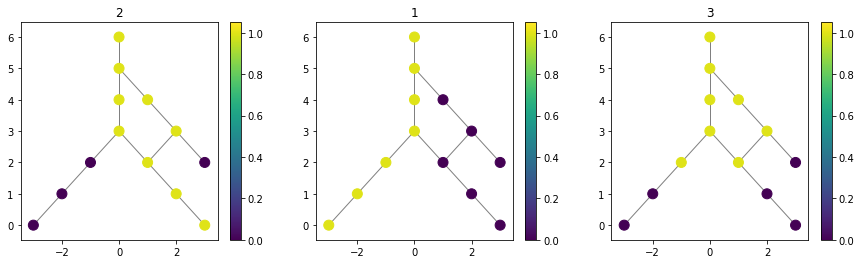

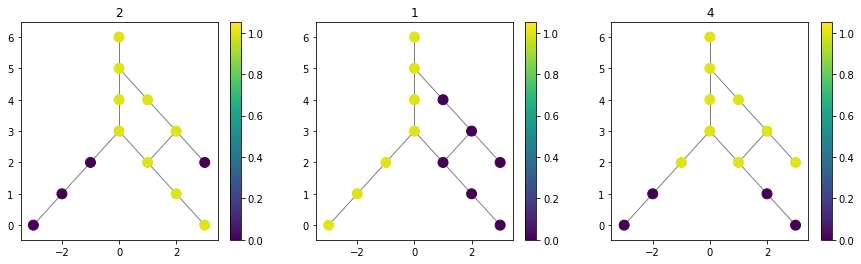

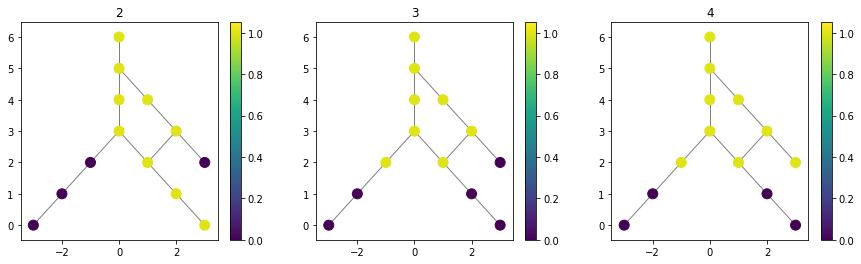

In [0]:
exp[1,0]=2 # 2,1,3        por la cantidad de nodos en común,el 1 tiene nodos en una rama totalmente diferente
exp[1,1]=2 # 2,1,4        por la cantidad de nodos en común,el 1 tiene nodos en una rama totalmente diferente
exp[1,2]=0 # 2,3,4        por la cantidad de nodos de diferencia, tanto el 3 como el 4 tienen dos etiqutas faltantes en una rama, una etiqueta sobrante en una rama y ademas el 4 tiene una sobrante en la rama máás a la derecha
plot_genes([2,1,3])
plot_genes([2,1,4])
plot_genes([2,3,4])

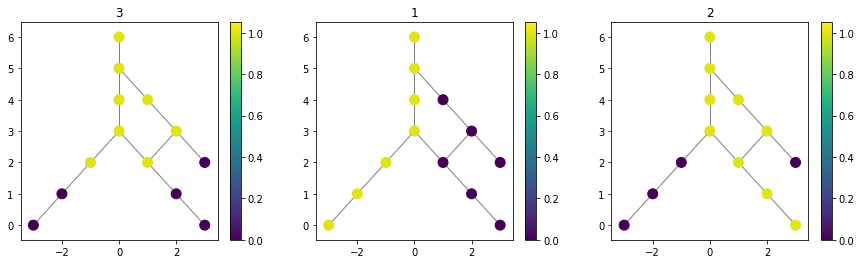

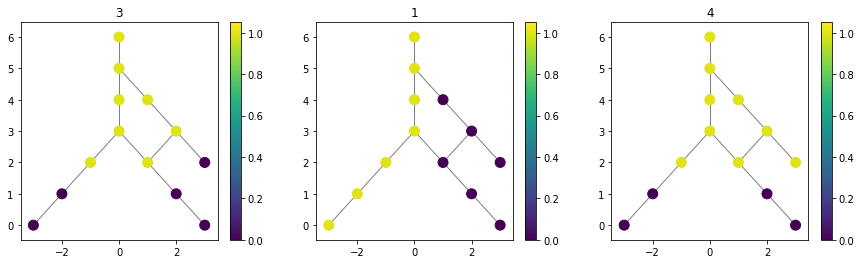

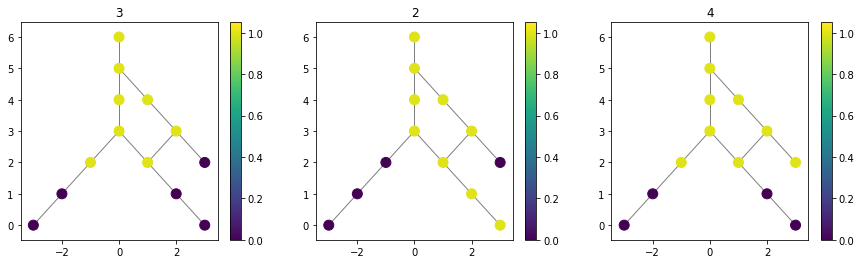

In [0]:
exp[2,0]=2 # 3,1,2        por la cantidad de nodos en común, el 3 es muy parecido al 2 salvo por tres etiquetas
exp[2,1]=2 # 3,1,4        por la cantidad de nodos en común, el 3 es muy parecido al 4, igual al caso anterior
exp[2,2]=2 # 3,2,4        por la cantidad de nodos en común, el 2 tiene dos etiquetas de mas y le falta una etiqueta, el 4 tiene una etiqueta de mas
plot_genes([3,1,2])
plot_genes([3,1,4])
plot_genes([3,2,4])

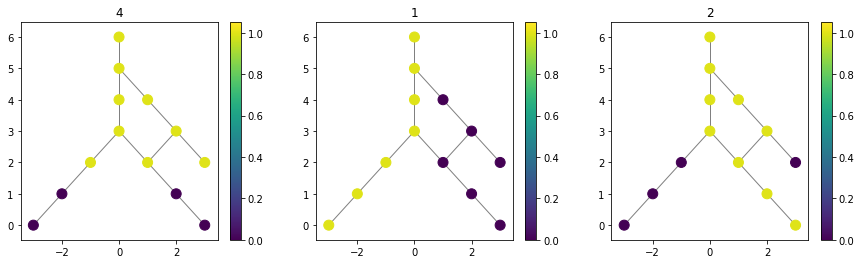

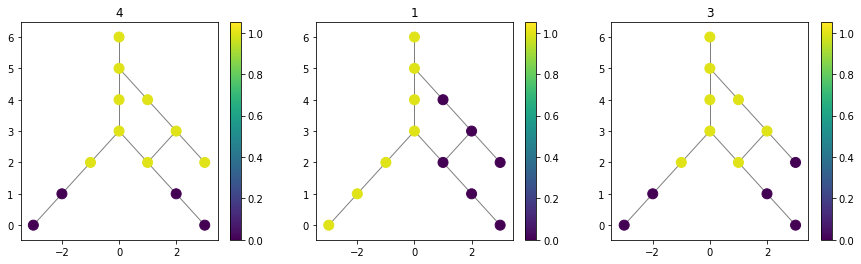

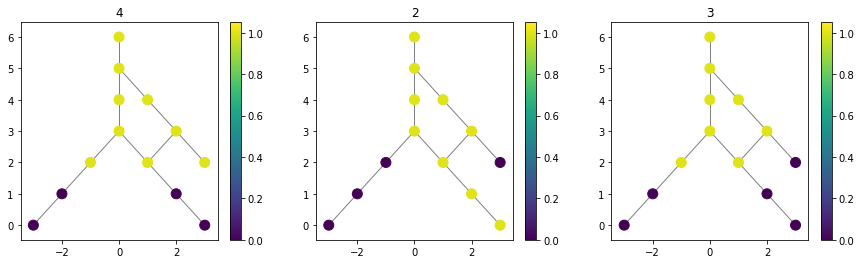

In [0]:
exp[3,0]=2 # 4,1,2        por la cantidad de nodos en común, el 4 es mucho máás parecido al 2
exp[3,1]=2 # 4,1,3        por la cantidad de nodos en común, el 4 es mucho máás parecido al 3
exp[3,2]=2 # 4,2,3        por la cantidad de nodos en común, porque conra ambos tiene un error al mismo nivel, pero el 2 agrega 2 errores mas a mayor especificidad, o sea, a mayor informacion
plot_genes([4,1,2])
plot_genes([4,1,3])
plot_genes([4,2,3])

# Análisis de umbrales

## Evaluación de las distancias con los umbrales con laplaciano completo

Text(0.5, 1.0, 'Comparacion del error en distintas medidas de distancia')

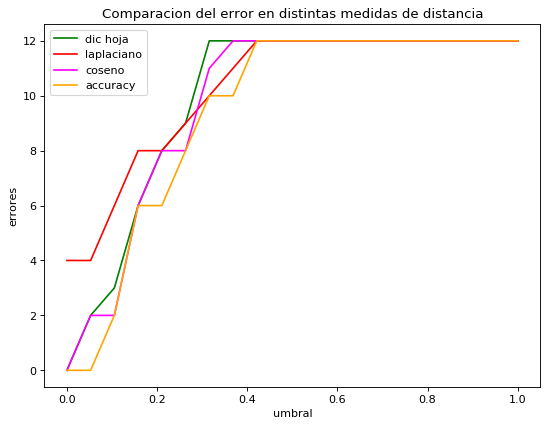

In [0]:
gamma = np.linspace(0,1,20)
cant_err = np.zeros((5,len(gamma)))

for i in range(len(gamma)):
  _, cant_err[0,i], _= exp_matrix_u(n_dist_D1,exp,gamma[i])
  _, cant_err[1,i], _= exp_matrix_u(n_dist_D2,exp,gamma[i])
  _, cant_err[2,i], _= exp_matrix_u(n_dist_B,exp,gamma[i])
  _, cant_err[3,i], _= exp_matrix_u(n_dist_C,exp,gamma[i])
  _, cant_err[4,i], _= exp_matrix_u(n_dist_A,exp,gamma[i])

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(gamma,cant_err[0,:],color='green',label='dic hoja')
#plt.plot(gamma,cant_err[1,:],color='blue',label='dic camino')
plt.plot(gamma,cant_err[2,:],color='red',label='laplaciano')
plt.plot(gamma,cant_err[3,:],color='magenta',label='coseno')
plt.plot(gamma,cant_err[4,:],color='orange',label='accuracy')
plt.legend()
plt.xlabel('umbral')
plt.ylabel('errores')
plt.title('Comparacion del error en distintas medidas de distancia')

## Evaluación con distintas cantidades de vectores en el laplaciano

Text(0.5, 1.0, 'Comparacion del error en distintas bases del laplaciano')

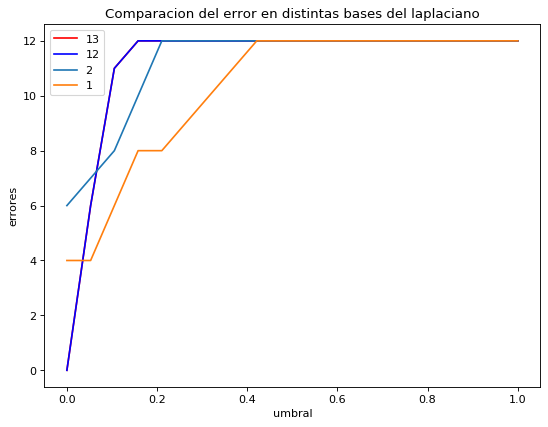

In [0]:
gamma = np.linspace(0,1,20)
cant_err = np.zeros((13,len(gamma)))

for k in range(13):
  
  dist_B = np.zeros((n,n))
  ggf = np.dot(B[:,-13+k:].T, genes.T).T
  for i in range(n):
    for j in range(i,n):
      dist_B[i,j] = np.linalg.norm(ggf[i,:]-ggf[j,:])
  dist_B = dist_B + dist_B.T

  dist_max_B = sum(sum(np.power(B[:,-13+k:],2)))
  n_dist_B = dist_B/dist_max_B

  for i in range(len(gamma)):
    _, cant_err[k,i], _= exp_matrix_u(n_dist_B,exp,gamma[i])

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(gamma,cant_err[0,:],color='red',label='13')
plt.plot(gamma,cant_err[1,:],color='blue',label='12')
#plt.plot(gamma,cant_err[2,:],color='green',label='11')
#plt.plot(gamma,cant_err[3,:],label='10')
#plt.plot(gamma,cant_err[4,:],label='9')
#plt.plot(gamma,cant_err[5,:],label='8')
#plt.plot(gamma,cant_err[6,:],color='magenta',label='7')
#plt.plot(gamma,cant_err[7,:],label='6')
#plt.plot(gamma,cant_err[8,:],label='5')
#plt.plot(gamma,cant_err[9,:],label='4')
#plt.plot(gamma,cant_err[10,:],color='orange',label='3')
plt.plot(gamma,cant_err[11,:],label='2')
plt.plot(gamma,cant_err[12,:],label='1')
plt.legend()
plt.xlabel('umbral')
plt.ylabel('errores')
plt.title('Comparacion del error en distintas bases del laplaciano')

## Evaluación en todos los casos

Error Accuracy :       9.3
Error Coseno :         9.65
Error Base hoja :      9.8
Error Base caminos :   9.8
Error Lap 1 :         10.2
Error Lap 12 :        11.05
Error Lap 13 :        11.05
Error Lap 2 :         11.15
Error Lap 8 :         11.4
Error Lap 7 :         11.4
Error Lap 3 :         11.4
Error Lap 6 :         11.45
Error Lap 5 :         11.45
Error Lap 9 :         11.45
Error Lap 11 :        11.5
Error Lap 10 :        11.5
Error Lap 4 :         11.55


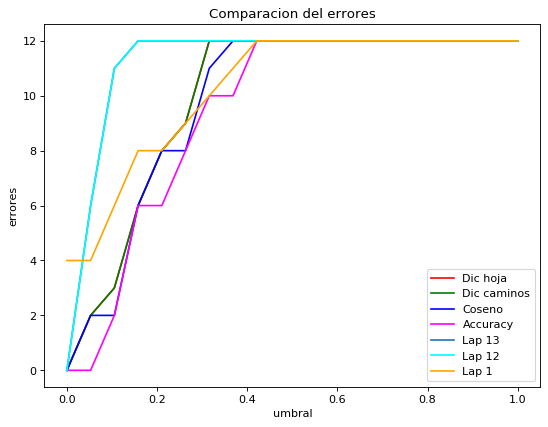

In [0]:
cant_umbrales = 20
gamma = np.linspace(0,1,cant_umbrales)
cant_err = np.zeros((17,len(gamma)))

for i in range(len(gamma)):
  _, cant_err[0,i], _= exp_matrix_u(n_dist_D1,exp,gamma[i])
  _, cant_err[1,i], _= exp_matrix_u(n_dist_D2,exp,gamma[i])
  _, cant_err[2,i], _= exp_matrix_u(n_dist_C,exp,gamma[i])
  _, cant_err[3,i], _= exp_matrix_u(n_dist_A,exp,gamma[i])

for k in range(13):
  
  dist_B = np.zeros((n,n))
  ggf = np.dot(B[:,-13+k:].T, genes.T).T
  for i in range(n):
    for j in range(i,n):
      dist_B[i,j] = np.linalg.norm(ggf[i,:]-ggf[j,:])
  dist_B = dist_B + dist_B.T

  dist_max_B = sum(sum(np.power(B[:,-13+k:],2)))
  n_dist_B = dist_B/dist_max_B

  for i in range(len(gamma)):
    _, cant_err[k+4,i], _= exp_matrix_u(n_dist_B,exp,gamma[i])

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(gamma,cant_err[0,:],color='red',label='Dic hoja')
plt.plot(gamma,cant_err[1,:],color='green',label='Dic caminos')
plt.plot(gamma,cant_err[2,:],color='blue',label='Coseno')
plt.plot(gamma,cant_err[3,:],color='magenta',label='Accuracy')
plt.plot(gamma,cant_err[4,:],label='Lap 13')
plt.plot(gamma,cant_err[5,:],color='cyan',label='Lap 12')
#plt.plot(gamma,cant_err[6,:],label='Lap 11')
#plt.plot(gamma,cant_err[7,:],label='Lap 10')
#plt.plot(gamma,cant_err[8,:],label='Lap 9')
#plt.plot(gamma,cant_err[9,:],label='Lap 8')
#plt.plot(gamma,cant_err[10,:],label='Lap 7')
#plt.plot(gamma,cant_err[11,:],label='Lap 6')
#plt.plot(gamma,cant_err[12,:],label='Lap 5')
#plt.plot(gamma,cant_err[13,:],label='Lap 4')
#plt.plot(gamma,cant_err[14,:],label='Lap 3')
#plt.plot(gamma,cant_err[15,:],label='Lap 2')
plt.plot(gamma,cant_err[16,:],color='orange',label='Lap 1')
plt.legend()
plt.xlabel('umbral')
plt.ylabel('errores')
plt.title('Comparacion del errores')

errores_totales = []
for i in range(17):
  errores_totales.append(sum(cant_err[i,:])/cant_umbrales)
errores_totales = np.asarray(errores_totales)
idx = errores_totales.argsort()

etiquetas = ['Base hoja','Base caminos','Coseno','Accuracy','Lap 13','Lap 12','Lap 11','Lap 10','Lap 9','Lap 8','Lap 7','Lap 6','Lap 5','Lap 4','Lap 3','Lap 2','Lap 1']
espacios = ['    ',' ','       ','     ','      ','      ','      ','      ','       ','       ','       ','       ','       ','       ','       ','       ','       ']
for i in range(17):
  print('Error',etiquetas[idx[i]],':',espacios[idx[i]],errores_totales[idx[i]])

## Evaluación con rango de umbrales reducido

Error Accuracy :       6.6
Error Coseno :         7.3
Error Base hoja :      7.6
Error Base caminos :   7.6
Error Lap 1 :          8.4
Error Lap 12 :        10.1
Error Lap 13 :        10.1
Error Lap 2 :         10.3
Error Lap 8 :         10.8
Error Lap 7 :         10.8
Error Lap 3 :         10.8
Error Lap 6 :         10.9
Error Lap 5 :         10.9
Error Lap 9 :         10.9
Error Lap 11 :        11.0
Error Lap 10 :        11.0
Error Lap 4 :         11.1


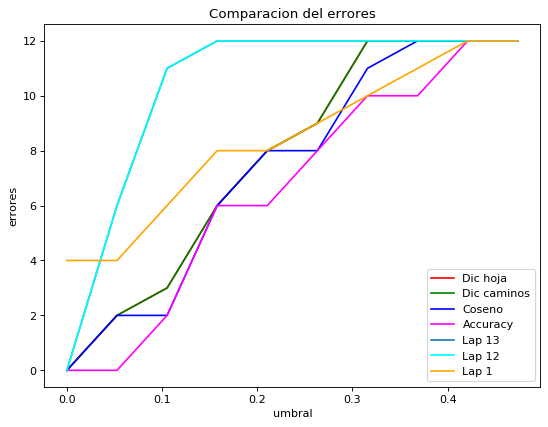

In [0]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(gamma[0:10],cant_err[0,0:10],color='red',label='Dic hoja')
plt.plot(gamma[0:10],cant_err[1,0:10],color='green',label='Dic caminos')
plt.plot(gamma[0:10],cant_err[2,0:10],color='blue',label='Coseno')
plt.plot(gamma[0:10],cant_err[3,0:10],color='magenta',label='Accuracy')
plt.plot(gamma[0:10],cant_err[4,0:10],label='Lap 13')
plt.plot(gamma[0:10],cant_err[5,0:10],color='cyan',label='Lap 12')
#plt.plot(gamma[0:10],cant_err[6,0:10],label='Lap 11')
#plt.plot(gamma[0:10],cant_err[7,0:10],label='Lap 10')
#plt.plot(gamma[0:10],cant_err[8,0:10],label='Lap 9')
#plt.plot(gamma[0:10],cant_err[9,0:10],label='Lap 8')
#plt.plot(gamma[0:10],cant_err[10,0:10],label='Lap 7')
#plt.plot(gamma[0:10],cant_err[11,0:10],label='Lap 6')
#plt.plot(gamma[0:10],cant_err[12,0:10],label='Lap 5')
#plt.plot(gamma[0:10],cant_err[13,0:10],label='Lap 4')
#plt.plot(gamma[0:10],cant_err[14,0:10],label='Lap 3')
#plt.plot(gamma[0:10],cant_err[15,0:10],label='Lap 2')
plt.plot(gamma[0:10],cant_err[16,0:10],color='orange',label='Lap 1')
plt.legend()
plt.xlabel('umbral')
plt.ylabel('errores')
plt.title('Comparacion del errores')

errores_totales = []
for i in range(17):
  errores_totales.append(sum(cant_err[i,0:10])/10)
errores_totales = np.asarray(errores_totales)
idx = errores_totales.argsort()

etiquetas = ['Base hoja','Base caminos','Coseno','Accuracy','Lap 13','Lap 12','Lap 11','Lap 10','Lap 9','Lap 8','Lap 7','Lap 6','Lap 5','Lap 4','Lap 3','Lap 2','Lap 1']
espacios = ['    ',' ','       ','     ','      ','      ','      ','      ','       ','       ','       ','       ','       ','       ','       ','       ','        ']
for i in range(17):
  print('Error',etiquetas[idx[i]],':',espacios[idx[i]],errores_totales[idx[i]])